In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imripy.halo
from imripy import merger_system as ms
import time

## Compare the analytic mass function of the halo profiles with the numeric integration

In [ ]:
def CompareMassFunction(halo, r_grid, ax):
    tic = time.perf_counter()
    m_ana = halo.mass(r_grid)  # Here we call the analytic expression
    toc = time.perf_counter()
    t_ana = toc - tic

    tic = time.perf_counter()
    m_num = imripy.halo.MatterHalo.mass(halo, r_grid) # Here we call the numerical odeint integration in the base class
    #m_num = [imripy.halo.MatterHalo.mass(halo, r) for r in r_grid]  # Here we call the numerical quad integration in the base class
    toc = time.perf_counter()
    t_num = toc - tic

    print("Comparing implementation for " + str(halo))
    print("elapsed time in analytic case: ", t_ana)
    print("elapsed time in numeric case:", t_num)
    print("The average relative error is ", np.average(np.abs(m_num/m_ana - 1.)))
    print("The maximal relative error is ", np.max(np.abs(m_num/m_ana - 1.)))

    l, = ax.loglog(r_grid, m_ana, alpha=0.5, label=str(halo) + ',analytic')
    ax.loglog(r_grid, m_num, color=l.get_c(), linestyle='--', label=str(halo) + ',numeric')

In [ ]:
n = 1000
r_grid = np.geomspace(1e-5, 1e5, n)

# Test numerical and analytical mass functions
plt.figure(figsize=(16, 10)); ax = plt.gca()
CompareMassFunction(imripy.halo.ConstHalo(1.), r_grid, ax)
CompareMassFunction(imripy.halo.NFW(1., 1e2), r_grid, ax)
CompareMassFunction(imripy.halo.SpikedNFW(1., 1e3, 1e-2, 7./3.), r_grid, ax)
CompareMassFunction(imripy.halo.Spike(1., 1e-2, 7./3.), r_grid, ax)
CompareMassFunction(imripy.halo.Hernquist(1., 1e0), r_grid, ax)
ax.set_xlabel("r")
ax.set_ylabel("m")
plt.grid(); plt.legend();
plt.show()

## Compare the results from the Eddington inversion procedure with the analytic equations

In [ ]:
from scipy.integrate import quad, odeint
from scipy.interpolate import interp1d

In [ ]:
def TestEddingtonInversion(halo, r_grid, ax_r, ax_eps, extPotential=None, f_ana=None, pot_ana=None):
    if extPotential is None:  # Invert density function in its own potential
        integrand = lambda r, m: halo.mass(np.abs(r))/r**2
        Phi_inf = quad(integrand, r_grid[-1], np.inf, args=(0.), limit=200)[0]
        Phi_inf = np.clip(Phi_inf, 1e-50, None)
        extPotential =  odeint(integrand, Phi_inf, -r_grid[::-1], tfirst=True, atol=1e-10, rtol=1e-10)[::-1,0]
        extPotential = interp1d(r_grid, extPotential, kind='cubic', bounds_error=False, fill_value=(0.,0.))

    if not pot_ana is None:
        l, = ax_r.loglog(r_grid, extPotential(r_grid), linestyle='--', label=str(halo) + ' $\Phi$, recovered')
        ax_r.loglog(r_grid, pot_ana(r_grid), color=l.get_c(), alpha=0.5, label=str(halo) + ' $\Phi$, analytic')

    Eps_grid = np.geomspace(extPotential(r_grid[-1]), extPotential(r_grid[0]), 500)
    haloRec = imripy.halo.DynamicSS.FromStatic(Eps_grid, halo, extPotential)   # Here the Eddington inversion is called
    
    l, = ax_r.loglog(r_grid, halo.density(r_grid), alpha=0.5, label=str(halo) + ',static')  # Plot for comparison
    ax_r.loglog(r_grid, haloRec.density(r_grid), color=l.get_c(), linestyle='--', label=str(halo) + ',recovered')
    ax_eps.loglog(Eps_grid, haloRec.f_grid, color=l.get_c(), linestyle='--', label=str(halo) +',recovered')
    if not f_ana is None:
        ax_eps.loglog(Eps_grid, f_ana(Eps_grid), color=l.get_c(), alpha = 0.5 , label=str(halo) + ',analytic')
    return haloRec

In [ ]:
fig, (ax_r, ax_eps) = plt.subplots(2, 1, figsize=(20,20));
n = 1000
r_grid = np.geomspace(1e-5, 1e5, n)

# Test Eddington inversion for Spike profile with known analytic equations
Spike = imripy.halo.Spike(1., 1e-2, 7./3.)
extPotential = lambda r : 1./r
from scipy.special import gamma
f_ana = lambda E : Spike.rho_spike * Spike.alpha*(Spike.alpha-1.)/(2.*np.pi)**(3./2.) * (Spike.r_spike/1.)**Spike.alpha * gamma(Spike.alpha-1.)/gamma(Spike.alpha-1./2.) * E**(Spike.alpha-3./2.)
TestEddingtonInversion( Spike , r_grid, ax_r, ax_eps, extPotential, f_ana)

# Test Eddington inversion for Hernquist profile with known analytic equations
Hern = imripy.halo.Hernquist(1., 1e1)
def f_ana_Hern(Eps):
    M = 2.*np.pi * Hern.rho_s * Hern.r_s**3
    E = Eps*Hern.r_s/M
    return (M * Hern.r_s)**(-3./2.)/np.sqrt(2)/(2.*np.pi)**3 * np.sqrt(E)/(1-E)**2  *( (1.-2*E)*(8.*E**2 - 8.*E - 3.) + 3.*np.arcsin(np.sqrt(E)) / np.sqrt(E*(1-E))  )
def pot_ana_Hern(r):
    M = 2.*np.pi * Hern.rho_s * Hern.r_s**3
    return M/(r + Hern.r_s)

TestEddingtonInversion( Hern , r_grid, ax_r, ax_eps, extPotential=None, f_ana=f_ana_Hern, pot_ana=pot_ana_Hern)

ax_eps.grid(); ax_eps.legend(); ax_eps.set_xlabel(r"$\varepsilon$"); ax_eps.set_ylabel("f")
ax_r.grid(); ax_r.legend(); ax_r.set_xlabel("r")
plt.show()

### Compare Spike parametrizations

In [ ]:
m1 = 1e3 * ms.solar_mass_to_pc
alpha = 7./3.
rho_spike = 226*ms.solar_mass_to_pc
r_spike = ( (3-alpha)* 0.2**(3-alpha) * m1 / 2. / np.pi / rho_spike)**(1./3)
s1 = imripy.halo.Spike(rho_spike, r_spike, alpha)
rho_6 = 5.448*1e15 * ms.solar_mass_to_pc
s2 = imripy.halo.Spike.FromRho6(rho_6, m1, alpha)
print(s1.rho_spike, s1.r_spike, s1.alpha)
print(s2.rho_spike, s2.r_spike, s2.alpha)

## Test averaging method

In [ ]:
m1 = 1e3 * ms.solar_mass_to_pc
m2 = 1. * ms.solar_mass_to_pc
alpha = 7./3.
rho_spike = 226*ms.solar_mass_to_pc
r_spike = ( (3-alpha)* 0.2**(3-alpha) * m1 / 2. / np.pi / rho_spike)**(1./3)
sp_stat = ms.SystemProp(m1, m2, imripy.halo.Spike(rho_spike, r_spike, alpha))

In [ ]:
def makeDynamicSpike(sp_stat):
    extPotential = lambda r:sp_stat.m1/r
    r_grid = np.geomspace(1e-1*sp_stat.r_isco(), 1e8*sp_stat.r_isco(), 100)
    Eps_grid = np.geomspace(extPotential(r_grid[-1]), extPotential(r_grid[0]), 500)
    dynSpike = imripy.halo.DynamicSS.FromSpike(Eps_grid, sp_stat, sp_stat.halo)
    sp_dyn = ms.SystemProp(sp_stat.m1, sp_stat.m2, dynSpike, sp_stat.D)
    return sp_dyn

In [ ]:
sp_dyn  = makeDynamicSpike(sp_stat)

In [ ]:
plt.figure(figsize=(12,6))
sigma_acc = lambda r, v: (1+v**2)/v**2
a0 = 100.*sp_dyn.r_isco()
r0 = 80.*sp_dyn.r_isco()
v_s = np.sqrt(sp_dyn.m_total()*(2./a0 - 1./r0))

v = np.linspace(0., np.sqrt(2)*v_s, 100)

plt.plot(v/v_s, sigma_acc(r0, v), label="$F_{acc}$")
#plt.plot(v/v_s, v**2 * sp_dyn.halo.f(sp_dyn.halo.potential(r0) - 0.5*v**2), label="$v^2 f$")
plt.axhline(sp_dyn.halo.psdAveragedQuantity(sigma_acc, r0, v_max=v_s), label="$<F_{acc}>$", linestyle='--')
#plt.axhline(sp_dyn.halo.density(r0, v_max=v_s)/v_s**3, label="$<F_{acc}>'$", linestyle='-.', color='red')
plt.axhline(sigma_acc(r0, v_s), label="$F_{acc}$")
print("relative strength: ", sp_dyn.halo.psdAveragedQuantity(sigma_acc, r0, v_max=v_s)/sigma_acc(r0, v_s))
plt.legend(); plt.yscale('log')
plt.grid()

In [ ]:
plt.figure(figsize=(12,6))

a0 = 100.*sp_dyn.r_isco()
r0 = 80.*sp_dyn.r_isco()
v_s = np.sqrt(sp_dyn.m_total()*(2./a0 - 1./r0))

sigma_acc = lambda r, v: 1./(v-v_s)**4
v = np.linspace(0., np.sqrt(2)*v_s, 100)

plt.plot(v/v_s, sigma_acc(r0, v), label="$F_{acc}$")
#plt.plot(v/v_s, v**2 * sp_dyn.halo.f(sp_dyn.halo.potential(r0) - 0.5*v**2), label="$v^2 f$")
plt.axhline(sp_dyn.halo.psdAveragedQuantity(sigma_acc, r0, v_max=v_s), label="$<F_{acc}>$", linestyle='--')
#plt.axhline(sp_dyn.halo.density(r0, v_max=v_s)/v_s**3, label="$<F_{acc}>'$", linestyle='-.', color='red')
plt.axhline(sigma_acc(r0, v_s), label="$F_{acc}$")
print("relative strength: ", sp_dyn.halo.psdAveragedQuantity(sigma_acc, r0, v_max=v_s)/sigma_acc(r0, v_s))
plt.legend(); plt.yscale('log')
plt.grid()

In [ ]:
def sigma_acc(delta_v, delta_v_min):
    return np.where(np.abs(delta_v) > delta_v_min, 1./delta_v**4, 0.)
plt.figure(figsize=(12,6))

a0 = 100.*sp_dyn.r_isco()
r0 = 80.*sp_dyn.r_isco()
v_s = np.sqrt(sp_dyn.m_total()*(2./a0 - 1./r0))

v = np.linspace(0., np.sqrt(2)*v_s, 100)
delta_v_min = np.geomspace(1e-5*v_s, v_s, 6)
plt.plot(v/v_s, sigma_acc(v+v_s, 0.), label="$\sigma_{acc}$")

color_cycle = plt.gca()._get_lines.prop_cycler
    
for dvm in delta_v_min:
    c =  next(color_cycle)['color']
    plt.axhline(sp_dyn.halo.psdAveragedQuantity(lambda r,v: sigma_acc(v+v_s, dvm), r0, v_max=v_s), label=f"$<\sigma_{{acc}}>, \Delta v_{{min}}={dvm/v_s:.0e}v_s$", linestyle='--', color=c)
#plt.plot(v/v_s, v**2 * sp_dyn.halo.f(sp_dyn.halo.potential(r0) - 0.5*v**2), label="$v^2 f$")
#plt.axhline(sp_dyn.halo.psdAveragedQuantity(sigma_acc, r0, v_max=v_s), label="$<F_{acc}>$", linestyle='--')
#plt.axhline(sp_dyn.halo.density(r0, v_max=v_s)/v_s**3, label="$<F_{acc}>'$", linestyle='-.', color='red')
#plt.axhline(sigma_acc(r0, v_s), label="$F_{acc}$")
#print("relative strength: ", sp_dyn.halo.psdAveragedQuantity(sigma_acc, r0, v_max=v_s)/sigma_acc(r0, v_s))
plt.legend(); plt.yscale('log')
plt.grid()

## Test Michel accretion density distribution

In [15]:
m1 = 1e3*ms.solar_mass_to_pc

#Kappa = 1./ms.g_cm3_to_invpc2
Kappa =1.
gamma = 4./3.

r_c = 100.*m1

halo = imripy.halo.MichelAccretion(m1, r_c, Kappa, gamma)
print(halo)

MichelAccretion(M=4.7999999999999996e-11, M_dot=1.1829215436114338e-24, M_dot/M_dot_Edd=3.432264781842266e-06, rho_c=5.778014140880662e-08, u_c=0.07071067811865475, kappa=1.0, Gamma=1.3333333333333333)


In [16]:
M_dot = 4.*np.pi * halo.r_c**2 * halo.u_c * halo.rho_c
rho_infty = (((1. + gamma*Kappa/(gamma-1.)*halo.rho_c**(gamma-1.))*np.sqrt(1.-2.*halo.M/halo.r_c + halo.u_c**2)
              -1.) * (gamma-1.)/gamma/Kappa)**(1./(gamma-1.))

halo_rec = imripy.halo.MichelAccretion.FromM_dot(m1, M_dot, rho_infty, Kappa, gamma)
print( halo_rec)

MichelAccretion(M=4.7999999999999996e-11, M_dot=1.1622309662244404e-24, M_dot/M_dot_Edd=3.372230758060308e-06, rho_c=5.583359951605328e-08, u_c=0.07031994310597299, kappa=1.0, Gamma=1.3333333333333333)


/media/data/Documents/PhD/imripy/src/imripy/halo.py:788: RuntimeWarning: invalid value encountered in power
  W2 = (1. - 2*self.M/r + u**2)
/media/data/Documents/PhD/imripy/src/imripy/halo.py:788: RuntimeWarning: invalid value encountered in power
  W2 = (1. - 2*self.M/r + u**2)
/media/data/Documents/PhD/imripy/src/imripy/halo.py:788: RuntimeWarning: invalid value encountered in power
  W2 = (1. - 2*self.M/r + u**2)


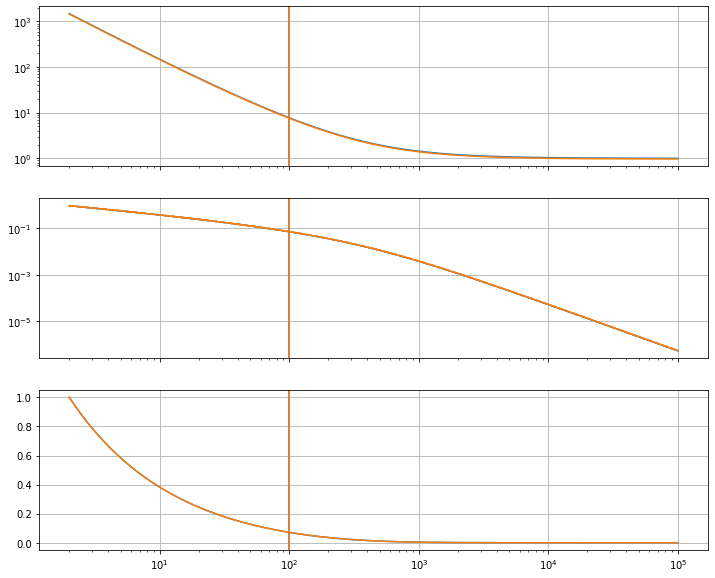

In [17]:
fig, (ax_rho, ax_u, ax_v) = plt.subplots(3,1, figsize=(12,10), sharex='all')
r_grid = np.geomspace(2.*m1, 1e5*m1, 200)

rho, u  = halo.solve_ode(r_grid)
l, = ax_rho.loglog(r_grid/m1, rho/rho_infty)
ax_u.loglog(r_grid/m1, u, color=l.get_c())
ax_u.loglog(r_grid/m1, halo.M_dot/(4.*np.pi*r_grid**2 * rho), linestyle='--')
ax_v.plot(r_grid/m1, u/np.sqrt(1. - 2*m1/r_grid + u**2), color=l.get_c())

ax_rho.axvline(halo.r_c/m1, color=l.get_c());ax_u.axvline(halo.r_c/m1, color=l.get_c()); ax_v.axvline(halo.r_c/m1, color=l.get_c())

rho, u  = halo_rec.solve_ode(r_grid)
l, = ax_rho.loglog(r_grid/m1, rho/rho_infty)
ax_u.loglog(r_grid/m1, u, color=l.get_c())
ax_u.loglog(r_grid/m1, halo.M_dot/(4.*np.pi*r_grid**2 * rho), linestyle='--')
ax_v.plot(r_grid/m1, halo.velocity(r_grid)[0], color=l.get_c())

ax_rho.axvline(halo.r_c/m1, color=l.get_c());ax_u.axvline(halo.r_c/m1, color=l.get_c()); ax_v.axvline(halo.r_c/m1, color=l.get_c())


ax_rho.grid(); ax_u.grid(); ax_v.grid()
ax_v.set_xscale('log')